# Load functions and modules

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

import hyperspy.api as hs


from hoglundTools._hyperspy import correlate_1D_in_2D, shift_Signal2D_along_axis
from hoglundTools._hyperspy.components import Gaussian2D

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/1290 [00:00<?, ?it/s]

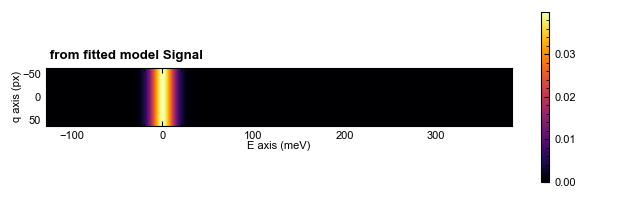

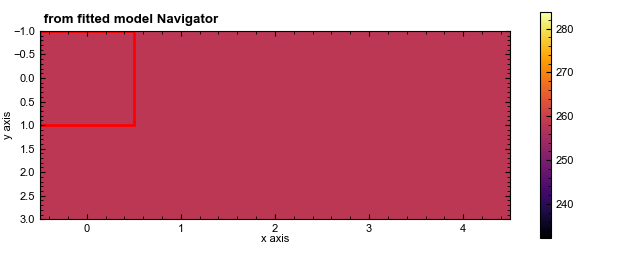

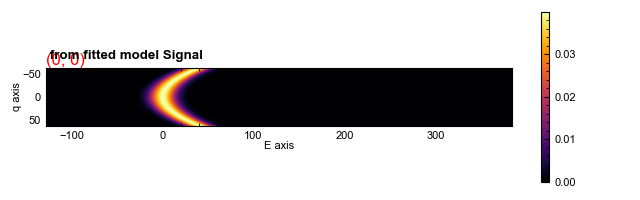

In [2]:
axes = [{'_type': 'UniformDataAxis', 'name': 'q', 'units': 'px',  'navigate': False, 'is_binned': False, 'size': 129, 'scale': 1.0, 'offset': -64.5},
        {'_type': 'UniformDataAxis', 'name': 'E', 'units': 'meV', 'navigate': False, 'is_binned': False, 'size': 1024, 'scale': 0.5, 'offset': -128.}]
s1 = hs.signals.Signal2D(np.zeros((129,1024)), axes=axes)

s1 = s1.as_signal1D('E')
s1 = s1.create_model()
g = hs.model.components1D.Gaussian(sigma=10, centre=0.0)
s1.append(g)
s1 = s1.as_signal().as_signal2D(('E','q'))
s1.plot()

axes = [dict(name='y', navigate=True,  scale=2, offset=0, size=2),
        dict(name='x', navigate=True,  scale=1, offset=0, size=5),
        dict(name='q', navigate=False, scale=1, offset=-64.5, size=129),
        dict(name='E', navigate=False, scale=0.5, offset=-128., size=1024)
       ]
si = hs.signals.Signal2D(np.zeros((2,5,129,1024)), axes=axes)

shift_xy = 10.
shift_q = 0.1
shift_nav = shift_xy * np.arange(0,10).reshape(si.axes_manager.navigation_shape[::-1])
shift_q   = (si.axes_manager['q'].axis*shift_q)**2
shifts_in = shift_nav[:,:,None] + shift_q

si = si.as_signal1D('E')
si = si.create_model()
g = hs.model.components1D.Gaussian(sigma=10, centre=0.0)
si.append(g)
g.centre.map['values'] = shifts_in
g.centre.map['is_set'] = True

si = si.as_signal().as_signal2D(('E','q'))
si.plot()

In [3]:
coef = []
pxs = []
nav_shape = si.axes_manager.navigation_shape
si.unfold_navigation_space()
for sig in si:
    lags, coe = correlate_1D_in_2D(sig.data, s1.data)
    coef.append(coe)
    pxs.append(lags[coe.argmax(1)])
si.fold()
coef = np.stack(coef)
pxs = np.stack(pxs)
shifts = si.axes_manager['E'].scale * pxs
shifts = shifts.reshape((*nav_shape[::-1],-1))
shifts.shape

(2, 5, 129)

[########################################] | 100% Completed | 121.26 ms


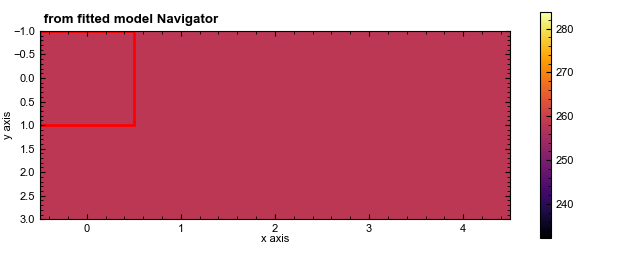

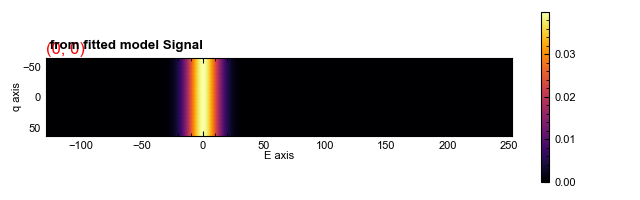

In [4]:
si = si.as_signal1D('E')
si.shift1D(-shifts)
si = si.as_signal2D(('E','q'))
si.plot()
